## kWTA_ei
This program explores the implementation of a kWTA network using a E-I network.

Sergio Verduzco,               
October 2017

In [1]:
from draculab import *
from matplotlib import pyplot as plt
import time
from matplotlib.animation import FuncAnimation

In [2]:
class ei_net():
    def __init__(self):
        # The history list will store strings containing the instructions doing parameter changes, 
        # building the network, or running a simulation.
        self.history = []
        """ All the default parameter dictionaries are below. """
        # parameter dictionary for the network
        self.net_params = {'min_delay' : 0.1, # notice delays below are set using this value
                           'min_buff_size' : 5 } 
        # parameter dictionary for the excitatory units
        self.unit_pars = {'init_val' : 0.5, 
                          'slope' : 2.,
                          'thresh' : 1.,
                          'tau' : 0.1,
                          'tau_fast' : 0.2,
                          'tau_slow' : 1.,
                          'type' : unit_types.sigmoidal }
        # geometry dictionary for both excitatory and inhibitory populations
        self.geom = {'shape':'sheet', 
                     'extent':[1.,1.], 
                     'center':[0.,0.], 
                     'arrangement':'grid', 
                     'rows':10, 
                     'columns':10, 
                     'jitter' : 0.02 }
        # parameters for the inhibitory units
        self.inh_pars = {'init_val' : 0.5, 
                         'slope' : 4.,
                         'thresh' : .5,
                         'tau' : 0.1,
                         'tau_fast' : 0.2,
                         'tau_slow' : 1.,
                         'type' : unit_types.sigmoidal } 
        # parameters for the input units
        self.n_units = {'inp' : 4} # number of input units
        self.inp_pars = {'type' : unit_types.source,
                         'init_val' : 0.,
                         'tau_fast' : 0.2,
                         'function' : lambda x: None }
        # E-E connections
        self.e2e_conn = {'connection_type' : 'convergent',
            'mask' : {'circular': {'radius': 0.15}},
            'kernel' : 1., #{'gaussian' : {'p_center' : 1.1, 'sigma' : 0.3} },
            'delays' : {'linear' : {'c' : self.net_params['min_delay'], 'a' : 0.1}},
            'weights' : {'linear' : {'c' : 0.3, 'a' : 0.1}},
            #'number_of_connections' : 6,
            'allow_autapses' : True,
            'allow_multapses' : False,
            'edge_wrap' : True,
            'boundary' : {'center': np.array(self.geom['center']), 'extent' : self.geom['extent']} }
        self.e2e_syn = {'type' : synapse_types.static }
        # E-I connections
        self.e2i_conn = {'connection_type' : 'convergent',
            'mask' : {'annular': {'inner_radius': 0.15, 'outer_radius': 0.4}},
            'kernel' : 1.,
            'delays' : {'linear' : {'c' : self.net_params['min_delay'], 'a' : 0.1}},
            'weights' : {'linear' : {'c' : 0.1, 'a' : 0.01}},
            #'number_of_connections' : 14,
            'edge_wrap' : True,
            'boundary' : {'center': np.array(self.geom['center']), 'extent' : self.geom['extent']} }
        self.e2i_syn = {'type' : synapse_types.static }
        # I-E connections
        self.i2e_conn = {'connection_type' : 'convergent',
            'mask' : {'circular': {'radius': 0.15}},
            'kernel' : 1,
            'delays' : {'linear' : {'c' : self.net_params['min_delay'], 'a' : 0.1}},
            'weights' : {'linear' : {'c' : -.1, 'a' : 0.001}},
            'edge_wrap' : True,
            'boundary' : {'center': np.array(self.geom['center']), 'extent' : self.geom['extent']} }
        self.i2e_syn = {'type' : synapse_types.homeo_inh,
            'lrate' : 0.1,
            'des_act' : 0.3 }
        # inputs to E and I
        self.i2u_conn_spec = {'rule' : 'all_to_all',
                 'delay' : self.net_params['min_delay'] }
        self.i2u_syn_spec = {'type' : synapse_types.bcm,
                'lrate' : 0.05,
                'init_w' : {'distribution' : 'equal_norm', 'norm' : 1.} }
        
    def build(self):
        """ Create the draculab network. """
        # store record of network being built
        self.history.append('build()')
        # Set derived parameters
        self.e2e_conn['delays'] = {'linear' : {'c' : self.net_params['min_delay'], 'a' : 0.1}}
        self.e2i_conn['delays'] = {'linear' : {'c' : self.net_params['min_delay'], 'a' : 0.1}}
        self.i2e_conn['delays'] = {'linear' : {'c' : self.net_params['min_delay'], 'a' : 0.1}}
        self.i2u_conn_spec['delay'] = self.net_params['min_delay']
        self.e2e_conn['boundary'] = {'center': np.array(self.geom['center']), 'extent' : self.geom['extent']}
        self.e2i_conn['boundary'] = {'center': np.array(self.geom['center']), 'extent' : self.geom['extent']}
        self.i2e_conn['boundary'] = {'center': np.array(self.geom['center']), 'extent' : self.geom['extent']}
        # Create an auxiliary topology object
        topo = topology()
        # Create network
        self.net = network(self.net_params)
        # Create excitatory population
        self.units = topo.create_group(self.net, self.geom, self.unit_pars)
        # Create group of inhibitory units
        self.inh = topo.create_group(self.net, self.geom, self.inh_pars)
        # Create input units
        self.inp = self.net.create(self.n_units['inp'], self.inp_pars)
        # E-E connections
        topo.topo_connect(self.net, self.units, self.units, self.e2e_conn, self.e2e_syn)
        # E-I connections
        topo.topo_connect(self.net, self.units, self.inh, self.e2i_conn, self.e2i_syn)
        # I-E connections
        topo.topo_connect(self.net, self.inh, self.units, self.i2e_conn, self.i2e_syn)
        # Connect the inputs to the units
        self.net.connect(self.inp, self.units, self.i2u_conn_spec, self.i2u_syn_spec)
        self.net.connect(self.inp, self.inh, self.i2u_conn_spec, self.i2u_syn_spec)
        
    def set_param(self, dictionary, entry, value):
        """ Change a value in a parameter dictionary. 
        
            dictionary: a string with the name of one of the parameter dictionaries in __init__
            entry: a string with the name of the entry we'll modify
            value: the value we'll assign (can be any appropriate Python object) 
        """
        if 'build()' in self.history:
            raise AssertionError('Setting a parameter value after network has been built')     
        self.__getattribute__(dictionary)[entry] = value  # set the new value
        self.history.append(dictionary + '[\'' + entry + '\'] = ' + str(value) ) # record assignment
            
    def make_sin_pulse(self, t_init, t_end, per, amp): 
        """ This function returns a function implementing a localized sinusoidal bump(s). """
        return lambda t : amp * ( np.sqrt( 0.5 * (1. + 
                      np.sin( np.pi*( 2.*(t - t_init)/per - 0.5 ) ) ) ) ) if (t_init < t and t < t_end) else 0.

    def input_vector(self):
        """This function returns an input vector. Different distributions can be implemented with this. """
        # right now it's just random vectors with unit norm
        vec = np.random.uniform(0., 1., self.n_units['inp'])
        return  vec / np.linalg.norm(vec)
        
    def run(self, n_pres, pres_time):
        """ Run a simulation, presenting n_pres patterns, each lasting pres_time. 
            
            Updates:
                self.all_times: 1-D numpy array with the times for each data point in all_activs.
                self.all_activs: 2-D numpy array with the activity of all units at each point in all_times. 
        """
        # store a record of this simulation
        self.history.append('run(' + str(n_pres) + ',' + str(pres_time) + ')') 
        # initialize storage of results
        self.all_times = []
        self.all_activs = []
        start_time = time.time()
        # present input patterns
        for pres in range(n_pres):
            print('Simulating presentation ' + str(pres), end='\r')
            pres_start = time.time()
            t = self.net.sim_time
            inp_vec = self.input_vector()
            for i in self.inp:
                self.net.units[i].set_function(self.make_sin_pulse(t, t+pres_time, pres_time, inp_vec[i-self.inp[0]]))
        
            times, activs, plants = self.net.run(pres_time)
            self.all_times.append(times)
            self.all_activs.append(activs)
            print('Presentation %s lasted %s seconds.' % (pres, time.time() - pres_start), end='\n')

        self.all_times = np.concatenate(self.all_times)
        self.all_activs = np.concatenate(self.all_activs, axis=1)
        print('Execution time is %s seconds' % (time.time() - start_time)) 
        return self # see rant on multiprocessing
        
    def basic_plot(self):
        #%matplotlib inline
        inp_fig = plt.figure(figsize=(10,5))
        inputs = np.transpose([self.all_activs[i] for i in self.inp])
        plt.plot(self.all_times, inputs, linewidth=1, figure=inp_fig)
        plt.title('Inputs')

        unit_fig = plt.figure(figsize=(10,5))
        some_acts = np.transpose(self.all_activs[[self.units[i] for i in [0,1,-1,-2]]])
        plt.plot(self.all_times, some_acts, figure=unit_fig)
        plt.title('Some unit activities')

        inh_fig = plt.figure(figsize=(10,5))
        some_inh = np.transpose(self.all_activs[[self.inh[i] for i in [0,1,-1,-2]]])
        plt.plot(self.all_times, some_inh, figure=inh_fig)
        plt.title('some inhibitory units')

        plt.show()
        
    def activ_anim(self, thr, slider=False):
        """ An animation to visualize the activity of the excitatory units. 
        
            Units whose activity surpasses 'thr' will be highlighted.
            It is assumed that this import statement has happened:
            from matplotlib.animation import FuncAnimation
        """
        %matplotlib qt5
        # notebook or qt5 

        self.unit_fig = plt.figure(figsize=(7,7))
        self.ax = self.unit_fig.add_axes([0, 0, 1, 1], frameon=False)
        self.ax.set_xlim(-1, 1), self.ax.set_xticks([])
        self.ax.set_ylim(-1, 1), self.ax.set_yticks([])
        xcoords = [ u.coordinates[0] for u in [self.net.units[i] for i in self.units] ]
        ycoords = [ u.coordinates[1] for u in [self.net.units[i] for i in self.units] ]
        self.scat = self.ax.scatter(xcoords, ycoords, s=20.*self.all_activs[self.units,0])
        self.n_data = len(self.all_activs[0])
        self.act_thr = thr
        
        if not slider:
            animation = FuncAnimation(self.unit_fig, self.update_act_anim, 
                                  interval=100, save_count=int(round(self.net.sim_time/self.net.min_delay)))    
            return animation
        else:
            from ipywidgets import interact
            widget = interact(self.update_act_anim, frame=(1,self.n_data))
            return widget
        
    def color_fun(self, activ):
        # given the units activity, maps into a color. activ may be an array.
        activ =  np.maximum(0.1,  activ*np.maximum(np.sign(activ - 0.8), 0.))
        return np.outer(activ, np.array([0., .5, 1., .5]))

    def update_act_anim(self, frame):
        # Each frame advances one simulation step (min_delay time units)
        idx = frame%self.n_data
        cur_time = self.net.min_delay*idx
        self.scat.set_sizes(300.*self.all_activs[self.units,idx])
        self.scat.set_color(self.color_fun(self.all_activs[self.units,idx]))
        self.unit_fig.suptitle('Time: ' + '{:f}'.format(cur_time))
        return self.ax,

    def conn_anim(self, source, sink):
        """ An animation to visualize the connectivity of Exc. and Inh. populations. 
    
            source and sink are lists with the IDs of the units whose connections we'll
            visualize. Each frame of the animation shows: for a particular unit in source,
            all the neurons in sink that receive connections from it (left plot), and for 
            a particular unit in sink, all the units in source that send it connections
            (right plot).
        
            It is assumed that this import statement has happened:
            from matplotlib.animation import FuncAnimation
        """
        %matplotlib qt5
        # notebook or qt5 
        
        # update_conn_anim uses these values
        self.len_source = len(source)
        self.len_sink = len(sink)
        self.source_0 = source[0]
        self.sink_0 = sink[0]

        # flattening net.syns, leaving only the source-sink connections 
        self.all_syns = []
        for syn_list in [self.net.syns[i] for i in sink]:
            syn_list = [s for s in syn_list if s.preID in source]
            self.all_syns += syn_list
    
        # getting lists with the coordinates of all source, sink units
        source_coords = [u.coordinates for u in [self.net.units[i] for i in source]]
        sink_coords = [u.coordinates for u in [self.net.units[i] for i in sink]]
        source_x = [c[0] for c in source_coords]
        source_y = [c[1] for c in source_coords]
        sink_x = [c[0] for c in sink_coords]
        sink_y = [c[1] for c in sink_coords]

        # setting colors
        self.std_src = [0., 0.5, 0.1, 0.5]
        self.std_snk = [1., 0.5, 0.5, 0.5]
        self.big_src = [0., 0., 0., 1.]
        self.big_snk = [0., 1., 0., 1.]

        # constructing figure, axes, path collections
        self.conn_fig = plt.figure(figsize=(9,5))
        self.ax1 = self.conn_fig.add_axes([0.0, 0.01, .49, 0.95], frameon=True, aspect=1)
        self.ax2 = self.conn_fig.add_axes([0.51, 0.01, .49, 0.95], frameon=True, aspect=1)
        self.src_col1 = self.ax1.scatter(source_x, source_y, s=2, c=self.std_src)
        self.snk_col1 = self.ax1.scatter(sink_x, sink_y, s=2, c=self.std_snk)
        self.src_col2 = self.ax2.scatter(source_x, source_y, s=2, c=self.std_src)
        self.snk_col2 = self.ax2.scatter(sink_x, sink_y, s=2, c=self.std_snk)
        self.ax1.set_title('sent connections')
        self.ax2.set_title('received connections')
        self.ax2.set_yticks([])
        
        animation = FuncAnimation(self.conn_fig, self.update_conn_anim, interval=500, blit=True)
        return animation

    def update_conn_anim(self, frame): 
        sou_u = frame%self.len_source # source unit whose receivers we'll visualize
        snk_u = frame%self.len_sink # sink unit whose senders we'll visualize
    
        # PLOTTING THE RECEIVERS OF sou_u ON THE LEFT AXIS
        source_sizes = np.tile(2, self.len_source)
        sink_sizes = np.tile(2, self.len_sink)
        source_colors = np.tile(self.std_src,(self.len_source,1))
        sink_colors = np.tile(self.std_snk, (self.len_sink,1))
        source_sizes[sou_u] = 30
        source_colors[sou_u] = self.big_src
        # getting targets of projections from the unit 'sou_u'
        targets = [syn.postID - self.sink_0 for syn in self.all_syns if syn.preID == sou_u + self.source_0]
        # setting the colors and sizes
        sink_colors[targets] = self.big_snk
        sink_sizes[targets] = 15
        self.src_col1.set_sizes(source_sizes)
        #ax1.get_children()[0].set_sizes(source_sizes)   # sizes for the source units
        self.snk_col1.set_sizes(sink_sizes)   
        self.src_col1.set_color(source_colors)
        self.snk_col1.set_color(sink_colors)
        
        # PLOTTING THE SENDERS TO snk_u ON THE RIGHT AXIS
        source_sizes = np.tile(2, self.len_source)
        sink_sizes = np.tile(2, self.len_sink)
        source_colors = np.tile(self.std_src, (self.len_source,1))
        sink_colors = np.tile(self.std_snk, (self.len_sink,1))
        sink_sizes[snk_u] = 30
        sink_colors[snk_u] = self.big_snk
        # getting senders of projections to the unit 'snk_u'
        senders = [syn.preID - self.source_0 for syn in self.all_syns if syn.postID == snk_u + self.sink_0]
        # setting the colors and sizes
        source_colors[senders] = self.big_src
        source_sizes[senders] = 15
        self.src_col2.set_sizes(source_sizes)
        self.snk_col2.set_sizes(sink_sizes)   
        self.src_col2.set_color(source_colors)
        self.snk_col2.set_color(sink_colors)
    
        return self.ax1, self.ax2,
    

In [9]:
""" This cell runs a simulation using the ei_net class. """
# init 
ei = ei_net()
# parameter changes
ei.set_param('net_params', 'min_buff_size', 4)
ei.set_param('geom', 'jitter', 0.0)
# build
ei.build()
# simulate
n_presentations = 1
t_presentation = 1
ei.run(n_presentations, t_presentation)


Presentation 0 lasted 9.617849111557007 seconds.
Execution time is 9.618375539779663 seconds


In [ ]:
""" Some plots to get a general idea. """
#%matplotlib inline
ei.basic_plot()

In [ ]:
""" Visualize the activity after the simulation. """
act_ani = ei.activ_anim(0.8, slider=False)
#act_ani.save('act_ani.mp4') # save animation as an mp4 file

In [ ]:
""" View the connections. """
conn_ani = ei.conn_anim(ei.inh, ei.units)

In [ ]:
""" Running again from the last state. """
# Executing run again overwrites the results from the last simulation.
n_presentations = 1
t_presentation = 4
ei.run(n_presentations, t_presentation)

In [ ]:
""" Saving simulation results. 
    A draculab network contains lists with functions, so it is not picklable. 
    But it can be serialized with dill: https://github.com/uqfoundation/dill 
"""
import dill as pickle # you can use it just like pickle!
F = open('pickled_run1.pkl', 'wb')
pickle.dump(ei, F)
F.close()

In [ ]:
""" Retrieving a 'dilled' ei_net object and running again. """
import dill as pickle
F = open('pickled_run1.pkl', 'rb')
ei = pickle.load(F)
F.close()
print('Initial sim_time: ' + str(ei.net.sim_time))
n_presentations = 1
t_presentation = 4
ei.run(n_presentations, t_presentation)

## Regarding multiprocessing/multithreading as done below.

When importing Pool from the `multiprocessing` module, `pool.map` will provide a multiprocess version of the `map` function.
When importing Pool from the `multiprocessing.dummy` module, `pool.map` will provide a multithread version of the `map` function.
See: http://chriskiehl.com/article/parallelism-in-one-line/

Both multithreading and multiprocessing can't currently work this way. 

As draculab currently is, you can't multithread because `scipy.integrate.odeint` uses the Isoda solver, which can't have two instances running at the same time. See: https://docs.scipy.org/doc/scipy-0.17.1/reference/generated/scipy.integrate.ode.html#scipy.integrate.odeint .

A possible solution is to replace odeint with `scipy.integrate.ode`, using the set_integrator method to set "dopri5" as the solver. This seems error prone, and probably isn't worth it considering the GIL issue with Python threads.

The problem with multiprocessing, as implemented with `multiprocessing.pool.map`, is that the draculab network instances need to be pickled, and yet, they are not picklable. The solution is to give Python a way to pickle the ei_net objects: https://stackoverflow.com/questions/1816958/cant-pickle-type-instancemethod-when-using-multiprocessing-pool-map . To achieve this, the simplest solution may be to use `dill`.

Since there is a `copyreg` module to give pickle the right functions to serialize/deserialize a particular type of object, it seemed like I could get away with:

    import dill
    import copyreg
    # The next lines specify the methods to pickle and unpickle draculab networks
    copyreg.constructor(dill.loads) # declares dill.loads to be a valid constructor
    copyreg.pickle(network, dill.dumps, dill.loads) 
Unfortunately, this causes the pickling process to go into untold (infinite?) depths of recursion, higher than 10000.

Fortunately, the makers of dill also have their own multiprocessing module, which works with dill:

https://stackoverflow.com/questions/19984152/what-can-multiprocessing-and-dill-do-together?rq=1

https://github.com/uqfoundation/pathos

This works well, but there is still one more caveat. My `ei_net.run` function stores its results in member arrays, as well as in the network's synaptic weights and state. When we call the `run` method with `ProcessingPool.map`, however, the `ei_net` object is not modifiy. `map` actually pickles the object, and ships it to a process where it is unpacked and worked on. This unpacked object is a clone of the original `ei_net` object, and it is discarded once its `run` method is finished (https://stackoverflow.com/questions/15857838/modify-object-in-python-multiprocessing#15858559). Thus, all the results are in objects that get discarded.

The solution I have is to make the `ei_net.run` method return its `ei_net` instance, so `pool.map` will return a list with the `ei_net` instances that were actually executed.
This is why the original `ei_nets` list used below replaced by the results of `pool.map`. Otherwise it would be left populated by instances that have never been run. 

In [9]:
""" Running multiprocess/multithread parameter exploration. """
import dill
from pathos.multiprocessing import ProcessingPool

class mp_ei():
    def __init__(self):
        self.n_procs = 5
        self.n_nets = 6
        self.n_pres = [1]*8  # number of presentations for each net
        self.t_pres = [1]*8  # time of each presentation for each net
        self.ei_nets = [ei_net() for _ in range(self.n_nets)]
        self.ei_nets[0].set_param('geom', 'rows', 10)
        self.ei_nets[0].set_param('geom', 'columns', 10)
        self.ei_nets[1].set_param('geom', 'rows', 10)
        self.ei_nets[1].set_param('geom', 'columns', 10)
        self.ei_nets[1].set_param('n_units', 'inp', 4)
        for ei_obj in self.ei_nets:
            ei_obj.build()
        
    def run_net(self, net_num):
        print('Running network %d' % (net_num))
        return self.ei_nets[net_num].run(self.n_pres[net_num], self.t_pres[net_num])
    
    def run_all(self):
        #from multiprocessing import Pool as thread_pool  # <--- multiprocessing
        #from multiprocessing.dummy import Pool as thread_pool   # <--- multithreading
        pool = ProcessingPool(nodes=self.n_procs) 
        print('Starting %d processes, %d networks' % (self.n_procs, self.n_nets))
        start_time = time.time()
        self.ei_nets = pool.map(self.run_net, range(self.n_nets))
        print('Processing finished after %s seconds' % (time.time() - start_time)) 
        #pool.close()
        #pool.join()
        
ei_set = mp_ei()
ei_set.run_all()

Starting 5 processes, 6 networks
Running network 0
Running network 1
Presentation 0 lasted 8.660087823867798 seconds.
Execution time is 8.661088228225708 seconds
Running network 2
Presentation 0 lasted 8.772937059402466 seconds.
Execution time is 8.773833751678467 seconds
Running network 3
Presentation 0 lasted 9.099879264831543 seconds.
Execution time is 9.10070514678955 seconds
Running network 4
Presentation 0 lasted 9.229637384414673 seconds.
Execution time is 9.230589151382446 seconds
Running network 5
Presentation 0 lasted 8.829009532928467 seconds.
Execution time is 8.830172061920166 seconds
Presentation 0 lasted 8.565251350402832 seconds.
Execution time is 8.566529035568237 seconds
Processing finished after 38.35536456108093 seconds


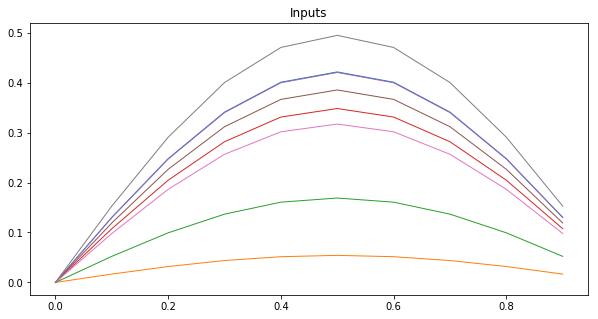

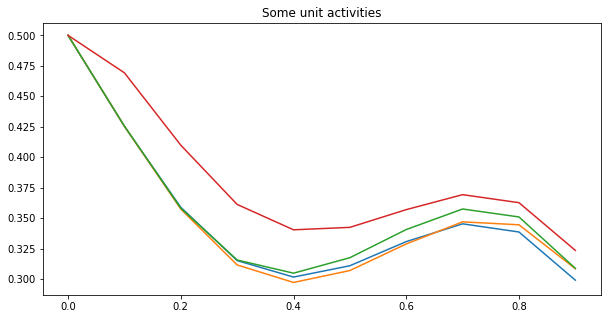

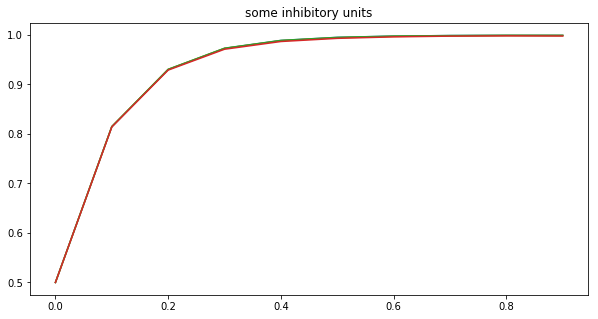

In [7]:
%matplotlib inline
ei_set.ei_nets[1].basic_plot()

In [11]:
act_ani0 = mt_ei.ei_nets[0].activ_anim(0.8, slider=True)

(<matplotlib.axes._axes.Axes at 0x7fc7a656b978>,)

In [13]:
dir(ProcessingPool)

['_AbstractWorkerPool__get_nodes',
 '_AbstractWorkerPool__imap',
 '_AbstractWorkerPool__init',
 '_AbstractWorkerPool__map',
 '_AbstractWorkerPool__nodes',
 '_AbstractWorkerPool__pipe',
 '_AbstractWorkerPool__set_nodes',
 '_ProcessPool__get_nodes',
 '_ProcessPool__set_nodes',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_clear',
 '_serve',
 'amap',
 'apipe',
 'clear',
 'close',
 'imap',
 'join',
 'map',
 'ncpus',
 'nodes',
 'pipe',
 'restart',
 'terminate',
 'uimap']